# PMLBmini experiments

This notebook runs the PMLBmini experiments, and compares RANDOM FEATURE BOOSTING and END2END to the saved PMLBmini models

NOTE that we assume tabmini is installed in the cwd https://github.com/RicardoKnauer/TabMini 

Should take no more than 30 minutes to run this notebook, ie run all models and datasets sequentially on a single CPU core

In [1]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import tabmini
import aeon
from aeon.visualisation import plot_critical_difference, plot_significance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

from models.gridsearch_wrapper import SKLearnWrapper
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet
from PMLBmini import test_on_PMLBmini

In [2]:
##############################################
#####      Equal/Random Guessing        ######
##############################################


class EqualGuessing(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.classes_ = np.unique(y)
        return self

    def predict_proba(self, X):
        """Guess probabilty 0.5 for each class"""
        # Guess [0.5, 0.5]
        return np.ones((X.shape[0], 2)) * 0.5

    def decision_function(self, X):
        # Get the probabilities from predict_proba
        proba = self.predict_proba(X)
        # Calculate the log of ratios for binary classification
        decision = np.log((proba[:, 1] + 1e-10) / (proba[:, 0] + 1e-10))
        return decision
    


In [3]:
# save_dir = "/home/nikita/Code/random-feature-boosting/results/PMLBmini_rocauc/"
# save_dir = "/home/nikita/Code/random-feature-boosting/results/PMLBmini_ghat_cv3accidentally/"
save_dir = "/home/nikita/Code/random-feature-boosting/results/PMLBmini/"
            
# train_guessing_and_xgboost, test_guessing_and_xgboost = test_on_PMLBmini(
#     EqualGuessing(),
#     'EqualGuessing',
#     [i for i in range(44)],
#     save_dir, 
#     other_saved_methods={"XGBoost"},
#     )

In [4]:
# !python PMLBmini.py \
#     --models E2E_MLP_ResNet \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#     --seed 42

In [5]:
# !python PMLBmini.py \
#     --models "Logistic(ours)" \
#     --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#     --seed 42

In [6]:
# # TODO wrong results for both built in rocauc and neglogloss
# for i in range(44):
#     !python PMLBmini.py \
#         --models "Logistic(ours)" \
#         --dataset_indices {i} \
#         --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#         --seed 42

In [7]:
# !python PMLBmini.py \
#     --models GRFRBoost_featSWIM_upiid_linesearchTrue_freezeFalse \
#     --dataset_indices 0 \
#     --save_dir /home/nikita/Code/random-feature-boosting/results/PMLBmini/ \
#     --seed 42

In [4]:
# Load the CSV and set the index
saved_results = pd.read_csv('https://raw.githubusercontent.com/RicardoKnauer/TabMini/master/plotting/results/test_scores_wide_3600.csv', delimiter=";", index_col=0)
saved_results.index.name = None
saved_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast
parity5,0.27,1.00,0.02,0.17,0.02
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73
analcatdata_aids,0.73,0.77,0.63,0.61,0.53
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91
labor,0.88,0.94,0.99,0.97,0.98
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87
lupus,0.84,0.79,0.82,0.85,0.79
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84


In [17]:
# join all the models
import itertools
model_names = []
for scoring in ["crossentropy"]:#["auc", "crossentropy"]:
    model_names.append(f"E2E_MLP_ResNet_{scoring}")
    model_names.append(f"RFNN_{scoring}")
    for feat in ["SWIM"]:
        for up in ["identity", "SWIM", "iid"]:
            for linesearch in [True, False]:
                for freeze in [True, False]:
                    for activation in ["tanh", "relu"]:
                            name = f"GRFRBoost_feat{feat}_up{up}_linesearch{linesearch}_freeze{freeze}_{activation}_{scoring}"
                            model_names.append(name)

In [24]:
# join all the models
import itertools
model_names = []
for scoring in ["crossentropy"]: # ["auc", "acc", "crossentropy"]:
    model_names.append(f"E2E_MLP_ResNet_{scoring}")
    model_names.append(f"RFNN_{scoring}")
    # for feat in ["SWIM"]:
    #     for up in ["identity", "SWIM", "iid"]:
    #         for linesearch in [True, False]:
    #             for freeze in [False]:
    #                 for activation in ["tanh", "relu"]:
    #                         name = f"GRFRBoost_feat{feat}_up{up}_linesearch{linesearch}_freeze{freeze}_{activation}_{scoring}"
    #                         model_names.append(name)
# model_names.append("GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse_tanh_crossentropy")
model_names.append("GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy")
model_names.append("GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu_crossentropy")

In [11]:
# # join all the models
# import itertools
# model_names = ["E2E_MLP_ResNet", "RFNN", #"RFNN_relu",
#                 "GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu",  
#                 #"GRFRBoost_featSWIM_upiid_linesearchFalse_freezeFalse",    
#                 #"GRFRBoost_featSWIM_upidentity_linesearchFalse_freezeFalse_relu", 
#                 #"GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse",           
#                 #"GRFRBoost_featSWIM_upiid_linesearchFalse_freezeFalse_relu",  
#                 #"GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeTrue",
#                ]
# # for feat, up, linesearch, freeze, relu in itertools.product(["SWIM"], ["SWIM"], [False], [False], ["_relu"]):
# #     name = f"GRFRBoost_feat{feat}_up{up}_linesearch{linesearch}_freeze{freeze}{relu}"
# #     model_names.append(name)

In [12]:
# ["SWIM"] # feat
# ["SWIM", "iid", "identity"] # up
# [False, True] # linesearch
# [False] # freeze
# ["", "relu"] # relu
# ["auc", "crossentropy", "acc"] # scoring
# #["ridge", "ridgecv"] # ghat module        
# 1*3*2*1*2*3

In [25]:
combined_results = saved_results.copy()
for model_name in model_names:
    try:
        path = f"{save_dir}{model_name}/test_0.csv"
        results_one_model = [pd.read_csv(f"{save_dir}{model_name}/test_{i}.csv", index_col=0)
                            for i in range(44)]
        df_one_model = pd.concat(results_one_model, axis=0)
        combined_results = combined_results.join(df_one_model)
    except:
        print(f"Failed to load {path}")
combined_results = combined_results.round(2)
combined_results

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast,E2E_MLP_ResNet_crossentropy,RFNN_crossentropy,GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy,GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu_crossentropy
parity5,0.27,1.00,0.02,0.17,0.02,0.48,0.16,0.18,0.17
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73,0.35,0.79,0.68,0.76
analcatdata_aids,0.73,0.77,0.63,0.61,0.53,0.45,0.74,0.59,0.65
analcatdata_bankruptcy,0.98,0.98,0.96,0.97,0.88,0.64,0.96,0.96,0.96
analcatdata_japansolvent,0.85,0.88,0.91,0.85,0.91,0.61,0.86,0.87,0.84
labor,0.88,0.94,0.99,0.97,0.98,0.48,0.96,0.97,0.95
analcatdata_asbestos,0.87,0.84,0.85,0.86,0.87,0.79,0.87,0.87,0.87
lupus,0.84,0.79,0.82,0.85,0.79,0.45,0.83,0.86,0.85
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34,0.55,0.40,0.37,0.49
analcatdata_cyyoung9302,0.89,0.85,0.87,0.87,0.84,0.77,0.87,0.87,0.87


In [26]:
combined_results.mean(axis=0).sort_values(ascending=False)

AutoGluon                                                                     0.879091
AutoPrognosis                                                                 0.853864
TabPFN                                                                        0.849545
GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu_crossentropy    0.847273
RFNN_crossentropy                                                             0.837273
GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy    0.833864
Logistic regression                                                           0.819318
HyperFast                                                                     0.816591
E2E_MLP_ResNet_crossentropy                                                   0.535455
dtype: float64

In [27]:
combined_results.rank(axis=1, ascending=False).mean(axis=0).sort_values(ascending=True)

TabPFN                                                                        3.579545
AutoGluon                                                                     3.670455
AutoPrognosis                                                                 3.829545
GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu_crossentropy    4.204545
RFNN_crossentropy                                                             4.636364
GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy    4.636364
Logistic regression                                                           5.704545
HyperFast                                                                     6.079545
E2E_MLP_ResNet_crossentropy                                                   8.659091
dtype: float64

In [28]:
nan_columns = combined_results.columns[combined_results.isna().any()].tolist()
print(nan_columns)
combined_results[nan_columns]
combined_results = combined_results.drop(columns=nan_columns)

[]


In [32]:
combined_results.query("RFNN_crossentropy > GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy")

,AutoPrognosis,AutoGluon,TabPFN,Logistic regression,HyperFast,E2E_MLP_ResNet_crossentropy,RFNN_crossentropy,GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_tanh_crossentropy,GRFRBoost_featSWIM_upidentity_linesearchTrue_freezeFalse_relu_crossentropy
analcatdata_fraud,0.86,0.80,0.79,0.77,0.73,0.35,0.79,0.68,0.76
analcatdata_aids,0.73,0.77,0.63,0.61,0.53,0.45,0.74,0.59,0.65
postoperative_patient_data,0.49,0.55,0.44,0.38,0.34,0.55,0.40,0.37,0.49
analcatdata_cyyoung8092,0.73,0.90,0.85,0.79,0.84,0.68,0.80,0.76,0.84
glass2,0.89,0.91,0.89,0.72,0.79,0.56,0.82,0.81,0.77
backache,0.60,0.72,0.75,0.72,0.78,0.45,0.76,0.72,0.68
sonar,0.88,0.93,0.92,0.85,0.89,0.51,0.86,0.85,0.88
analcatdata_lawsuit,0.99,0.99,1.00,1.00,0.98,0.15,1.00,0.99,1.00
spect,0.84,0.82,0.83,0.82,0.83,0.69,0.85,0.83,0.84
breast_cancer,0.69,0.69,0.73,0.70,0.69,0.42,0.72,0.68,0.70


In [ ]:
combined_results.query("RFNN_crossentropy == GRFRBoost_featSWIM_upSWIM_linesearchFalse_freezeFalse_tanh_crossentropy")

/home/nikita/Code/zephyrox/.conda/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:600: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  return result_to_tuple(hypotest_fun_out(*samples, **kwds))
/tmp/ipykernel_30284/3416593325.py:17: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


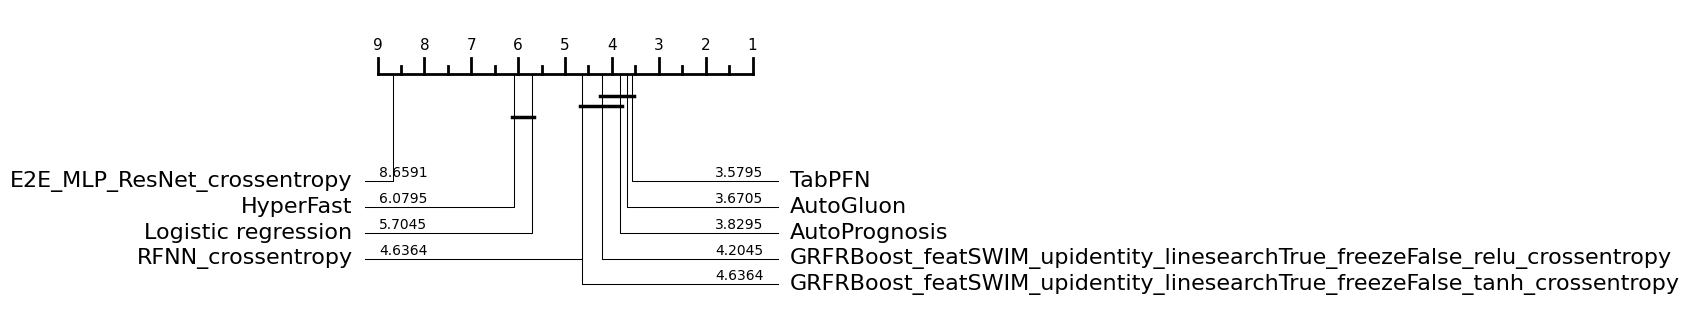

In [30]:
import matplotlib.pyplot as plt

# Generate the plot
plot = plot_critical_difference(combined_results.values,
                                combined_results.columns.tolist(), 
                                alpha=0.15, 
                                lower_better=False)

# Retrieve the figure and axes from the plot
fig = plot[0].figure
ax = plot[0]

# Adjust figure size
fig.set_size_inches(6, 3)

# Adjust layout
fig.tight_layout()

# Save the figures
fig.savefig(f"{save_dir}PMLBmini_critical_difference.eps", bbox_inches='tight')
fig.savefig(f"{save_dir}PMLBmini_critical_difference.png", bbox_inches='tight')

In [ ]:
import pandas as pd
import numpy as np

def create_latex_table(df):
    table = """
\\begin{table}[t]
\\caption{Test accuracies on the concentric circles task.}
\\label{tab:concentric-circles}
\\vskip 0.15in
\\begin{center}
\\begin{small}
\\begin{sc}
\\begin{tabular}{lcc}
\\toprule
Model & Mean Acc & Std Dev \\\\
\\midrule
"""
    for model_name in df.columns:
        accs = df[model_name]
        mean_acc = np.mean(accs)
        std_acc = np.std(accs)
        table += f"{model_name} & {mean_acc:.4f} & {std_acc:.4f} \\\\\n"
    
    table += """
\\bottomrule
\\end{tabular}
\\end{sc}
\\end{small}
\\end{center}
\\vskip -0.1in
\\end{table}
"""
    return table

# Example usage
# Assuming `results_df` is your pandas DataFrame
latex_table = create_latex_table(combined_results)
print(latex_table)

# experiment on single

In [ ]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import os
import pickle
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
from torch import Tensor, tensor
import pandas as pd
import tabmini
import aeon
from aeon.visualisation import plot_critical_difference, plot_significance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score

from models.base import LogisticRegression
from models.gridsearch_wrapper import SKLearnWrapper
from models.random_feature_representation_boosting import GradientRFRBoostClassifier
from models.end2end import End2EndMLPResNet

class Config:
    save_dir = Path.cwd() / "results" / "PMLBmini"



#download dataset, cache it
dataset_save_path = Config.save_dir / 'PMLBmini_dataset.pkl'
if not os.path.exists(dataset_save_path):
    print("Dataset not found, downloading")
    dataset = tabmini.load_dataset(reduced=False)
    os.makedirs(Config.save_dir, exist_ok=True)
    with open(dataset_save_path, 'wb') as f:
        pickle.dump(dataset, f)
else:
    print("Dataset found, loading")
    with open(dataset_save_path, 'rb') as f:
        dataset = pickle.load(f)

In [101]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 10: parity5
X, y = dataset["analcatdata_fraud"]
# X, y = dataset["parity5"]
scaler = MinMaxScaler()
#scaler = StandardScaler()
X = scaler.fit_transform(X)
X = torch.tensor(X).float()
y = torch.tensor(y.values)[..., None].float()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
X.shape

In [ ]:
# model = LogisticRegression(
#     n_classes=2,
#     l2_lambda=0.0001,
#     max_iter = 300,
# )
np.random.seed(42)
torch.manual_seed(42)

model = GradientRFRBoostClassifier(
    in_dim=X.shape[1],
    n_classes=2,
    l2_cls=0.001,
    l2_ghat=0.00001,
    n_layers=1,
    randfeat_xt_dim=128,
    randfeat_x0_dim=128,
    hidden_dim=128,
    upscale_type="SWIM",
    feature_type="SWIM",
    use_batchnorm=False,
    boost_lr=1,
    activation="tanh",
    do_linesearch=False,
    freeze_top_at_t=2,
    ghat_ridge_solver="solve",
)
model.fit(X_train, y_train)

from sklearn.metrics import roc_auc_score

logits = model(X_test)
print("logits", logits)
probs = nn.functional.sigmoid(logits)
# print("out and y", torch.cat([logits, y_test], dim=1))
# print("binary class pred and y", torch.cat([probs > 0.5, y_test], dim=1))
auc = roc_auc_score(y_test.numpy(), probs.detach().numpy())
print("test AUC:", auc)
print("test accuracy:", (probs > 0.5).eq(y_test).float().mean().item())
print("test cross-entropy:", nn.functional.binary_cross_entropy_with_logits(logits, y_test).item())

#train
model.eval()
logits = model(X_train)
probs = nn.functional.sigmoid(logits)
auc = roc_auc_score(y_train.numpy(), probs.detach().numpy())
print("train AUC:", auc)
print("train accuracy:", (probs > 0.5).eq(y_train).float().mean().item())
print("train cross-entropy:", nn.functional.binary_cross_entropy_with_logits(logits, y_train).item())

In [ ]:
# TODO cross entropy loss
# TODO ridgeCV


# bugfix

In [110]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 10: parity5
X, y = dataset["analcatdata_fraud"]
# X, y = dataset["parity5"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
X.shape

In [ ]:
from PMLBmini import WrapperGridSearch

model = WrapperGridSearch(
    param_grid={
        "modelClass": [GradientRFRBoostClassifier],
        "l2_cls": [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
        "l2_ghat": [0.01, 0.001, 0.0001, 0.00001],
        "n_layers": [1],
        "randfeat_xt_dim": [32],
        "randfeat_x0_dim": [32],
        "hidden_dim": [128],
        "upscale_type": ["identity"],
        "feature_type": ["SWIM"],
        "use_batchnorm": [False],
        "boost_lr": [1],
        "activation": ["tanh"],
        "do_linesearch": [False],
        "freeze_top_at_t": [2],
        "ghat_ridge_solver": ["solve"],
    },
    verbose=3,
    scaler=StandardScaler(),
    seed=42,
    scoring = "roc_auc",
)
model.fit(X_train, y_train)
pred_test = model.predict_proba(X_test)
pred_train = model.predict_proba(X_train)
print("test AUC:", roc_auc_score(y_test, pred_test[:, 1]))
print("test accuracy:", (pred_test.argmax(axis=1) == y_test).mean())
print("naive test acc", (y_test == 0).mean())
print("train AUC:", roc_auc_score(y_train, pred_train[:, 1]))